In [ ]:
# https://pypi.org/project/jiwer/
#!pip install jiwer

In [1]:
import os
import wave
from vosk import Model, KaldiRecognizer, SetLogLevel
import json
import requests
import jiwer
import pandas as pd

In [2]:
def transcribe_vosk(file_name):

    model_path = '/home/alex/projects/vosk-api/python/example/vosk-model-ru-0.10'
    phrases_list = []

    # read file
    wf = wave.open(file_name, "rb")

    # read model
    model = Model(model_path)
    rec = KaldiRecognizer(model, wf.getframerate())

    # recognizing
    while True:

        conf_score = []

        data = wf.readframes(4000)
        if len(data) == 0:
            break

        if rec.AcceptWaveform(data):
            accept = json.loads(rec.Result())
            if accept['text'] !='':

                accept_start	= str(accept['result'][0]['start'])
                accept_end   	= accept['result'][-1:][0]['end']
                accept_text		= str(accept['text'])

                for result_rec in accept['result']:
                    conf_score.append(float(result_rec['conf']))
                conf_mid = str(sum(conf_score)/len(conf_score))
                conf_score = []
                
                phrases_list.append(accept_text)
    return phrases_list

In [3]:
def transcribe_sova(file_name):
    url = "http://localhost:8888/asr/"
    f1 = open(file_name, 'rb')
    response = requests.post(url,files={"audio_blob": f1}).text
    return json.loads(response)['r'][0]['response'][0]['text']    

In [6]:
df = pd.DataFrame(columns = ['file', 'human_text', 'vosk_text', 'sova_text'])

In [7]:
data_path = 'data/'
transcribations_vosk = []
transcribations_sova = []
filelist = []
for root, dirs, files in os.walk(data_path):
    for filename in files:
        
        vosk_phrases = transcribe_vosk(data_path + filename)        
        transcribations_vosk.append(' '.join(str(item) for item in vosk_phrases))
                 
        transcribations_sova.append(transcribe_sova(data_path + filename))
        filelist.append(filename)
        
df.file = filelist
df.vosk_text = transcribations_vosk
df.sova_text = transcribations_sova

In [16]:
df

,file,human_text,vosk_text,sova_text
0,lo1615966037.2256002-out.wav,NaN,королев далее ну надо ремонтировать там я там ...,алло да но надо ремонтировать там кретину там ...
1,lo1615967475.2257111-out.wav,NaN,и и о а а вы вроде тоже она подбирала вроде бы...,алло так вроде тоже она подбирала вроде бежал ...
2,lo1615965189.2255215-out.wav,NaN,и и сельма а ага твоя моча раме впадина телом ...,у вас так ага знаете что я сейчас вечер в один...
3,lo1615967560.2257152-out.wav,NaN,доходах а вы извините у нас начал показывать с...,да да вы видел у нас начал показывать спасибо ...


In [26]:
human_text = []
# lo1615966037.2256002-out.wav
human_text.append('але да да ну надо ремонтировать там и это ну там комфорка плохо работает и надо еще метель смотреть да да да да ясно тогда ладно лучше я договорюсь хозяйку потому что угу хорошо ага спасибо')
# lo1615967475.2257111-out.wav
human_text.append('алло да ну вроде бы жена постирала вроде бы жалоб небыло вроде бы отжала хорошо да спасибо')
# lo1615965189.2255215-out.wav
human_text.append('слушаю вас ага вы знаете что я вчера вечером в одинадцать часов включила стиральную машину она бош натуральная немецкой сборки очень старая мах четыре ну и работала так быстро быстро быстро в одинадцать вечера и вот он вдруг погасло все выключилось и не включается света нету стиральная машина ну спасибо большое досвидания')
# lo1615967560.2257152-out.wav
human_text.append('да але а вы извините он у нас начал показывать спасибо большое за это за заботу что то там отдохнул маленько и показывать стал алё ага досвидания')
df.human_text = human_text

In [27]:
df

,file,human_text,vosk_text,sova_text
0,lo1615966037.2256002-out.wav,але да да ну надо ремонтировать там и это ну т...,королев далее ну надо ремонтировать там я там ...,алло да но надо ремонтировать там кретину там ...
1,lo1615967475.2257111-out.wav,алло да ну вроде бы жена постирала вроде бы жа...,и и о а а вы вроде тоже она подбирала вроде бы...,алло так вроде тоже она подбирала вроде бежал ...
2,lo1615965189.2255215-out.wav,слушаю вас ага вы знаете что я вчера вечером в...,и и сельма а ага твоя моча раме впадина телом ...,у вас так ага знаете что я сейчас вечер в один...
3,lo1615967560.2257152-out.wav,да але а вы извините он у нас начал показывать...,доходах а вы извините у нас начал показывать с...,да да вы видел у нас начал показывать спасибо ...


In [30]:
def error(ground_truth, hypothesis):
    wer = jiwer.wer(ground_truth, hypothesis)
    mer = jiwer.mer(ground_truth, hypothesis)
    wil = jiwer.wil(ground_truth, hypothesis)

    # faster, because `compute_measures` only needs to perform the heavy lifting once:
    measures = jiwer.compute_measures(ground_truth, hypothesis)
    return measures
    """wer = measures['wer']
    mer = measures['mer']
    wil = measures['wil']

    print('wer', wer)
    print('mer', mer)
    print('wil', wil)"""

In [35]:
vosk_wer = []
vosk_mer = []
vosk_wil = []
for row in range(len(df)):
    measures = error(df.iloc[row].human_text, df.iloc[row].vosk_text)
    vosk_wer.append(measures['wer'])
    vosk_mer.append(measures['mer'])
    vosk_wil.append(measures['wil'])
df['vosk_wer'] = vosk_wer
df['vosk_mer'] = vosk_mer
df['vosk_wil'] = vosk_wil

In [39]:
sova_wer = []
sova_mer = []
sova_wil = []
for row in range(len(df)):
    measures = error(df.iloc[row].human_text, df.iloc[row].sova_text)
    sova_wer.append(measures['wer'])
    sova_mer.append(measures['mer'])
    sova_wil.append(measures['wil'])
df['sova_wer'] = sova_wer
df['sova_mer'] = sova_mer
df['sova_wil'] = sova_wil

In [40]:
df

,file,human_text,vosk_text,sova_text,vosk_wer,vosk_mer,vosk_wil,sova_wer,sova_mer,sova_wil
0,lo1615966037.2256002-out.wav,але да да ну надо ремонтировать там и это ну т...,королев далее ну надо ремонтировать там я там ...,алло да но надо ремонтировать там кретину там ...,0.583333,0.583333,0.798387,0.583333,0.583333,0.776786
1,lo1615967475.2257111-out.wav,алло да ну вроде бы жена постирала вроде бы жа...,и и о а а вы вроде тоже она подбирала вроде бы...,алло так вроде тоже она подбирала вроде бежал ...,0.882353,0.833333,0.968858,0.764706,0.764706,0.921569
2,lo1615965189.2255215-out.wav,слушаю вас ага вы знаете что я вчера вечером в...,и и сельма а ага твоя моча раме впадина телом ...,у вас так ага знаете что я сейчас вечер в один...,0.596154,0.563636,0.769231,0.461538,0.452830,0.676538
3,lo1615967560.2257152-out.wav,да але а вы извините он у нас начал показывать...,доходах а вы извините у нас начал показывать с...,да да вы видел у нас начал показывать спасибо ...,0.481481,0.481481,0.670034,0.555556,0.555556,0.757576


In [47]:
df.to_csv('data.csv', index=False)
#pd.read_csv('data.csv')

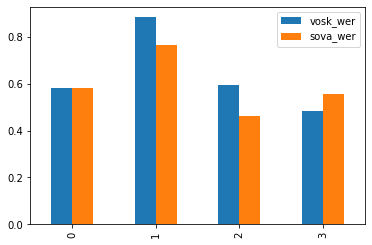

In [44]:
df.plot(y=["vosk_wer", "sova_wer"], kind="bar")

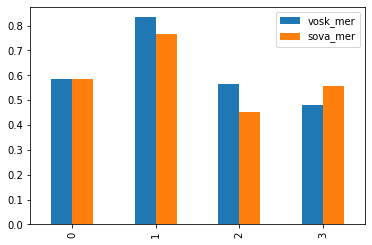

In [45]:
df.plot(y=["vosk_mer", "sova_mer"], kind="bar")

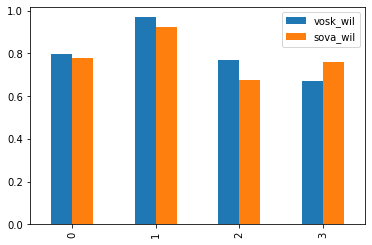

In [46]:
df.plot(y=["vosk_wil", "sova_wil"], kind="bar")